In [1]:
import sys, os, pickle
import torch
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from LDR_dim import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
from functools import partial
import matplotlib.pyplot as plt

In [2]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 1
macro_configs = config_generator()

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [3]:
# Load the variables from the npz file
data = np.load("/home/om2382/datasets/hemibrain_neurotransmitters-2/processed_data_2.npz")

# Extract variables
U_row = data['U_row']
s_row = data['s_row']
V_row = data['V_row']

U_col = data['U_col']
s_col = data['s_col']
V_col = data['V_col']

U_sk = data['U_sk']
s_sk = data['s_sk']
V_sk = data['V_sk']

J = data['J']
J_norm_row = data['J_norm_row']
J_norm_col = data['J_norm_col']
J_sk = data['J_sk']

nrn_roi_incoming = data['nrn_roi_incoming']
nrn_roi_outgoing = data['nrn_roi_outgoing']
types = data['types']
instances = data['instances']

In [6]:
W = torch.from_numpy(J_sk).type(torch.FloatTensor).to(0)
#x, r = sample_activity(1000, 0.1, 0.1, 2*W, T_save_delay=50, runga_kutta=True)

In [4]:
U = torch.from_numpy(U_sk).type(torch.FloatTensor).to(0)
V = torch.from_numpy(V_sk).type(torch.FloatTensor).to(0)
S = torch.from_numpy(s_sk).type(torch.FloatTensor).to(0)
gamma_diag = torch.einsum('ik, ik -> k', U, V)
N = len(S)

In [ ]:
rho_ = gamma_diag.cpu().detach().numpy()
D_ = S.cpu().detach().numpy()
(D_ * rho_).mean()**2#/(D_**2).mean()

In [5]:
### --- Generate LDRG matrix --- ###

X1 = torch.randn((N, N)).to(0)
X2 = torch.randn((N, N)).to(0)
Y = torch.randn((N, N)).to(0)
rho = gamma_diag
L = torch.sqrt((1 - torch.abs(rho))/N)*X1 + torch.sqrt(torch.abs(rho)/N)*Y
R = torch.sqrt((1 - torch.abs(rho))/N)*X2 + torch.sign(rho)*torch.sqrt(torch.abs(rho)/N)*Y

#g_eff = 8
D = torch.clone(S)
#g_correction = g_eff / torch.sqrt(torch.sum(D**2)/N)
#D = D * g_correction

W_gen = torch.einsum('ik, k, jk -> ij', L, D, R)
del L
del R

In [ ]:
W_gen.std()*np.sqrt(W_gen.shape[0])

In [6]:
U_gen, S_gen, V_gen = torch.svd(W_gen)

Text(0, 0.5, 'correlation')

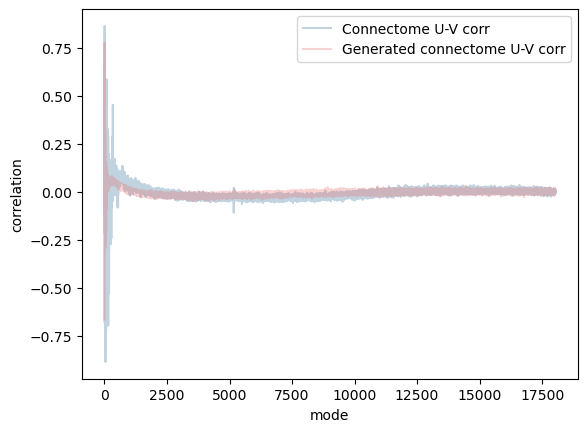

In [10]:
gamma_gen = torch.einsum('ij, ki -> jk', U_gen, V_gen.T)
plt.plot(gamma_diag.cpu().detach().numpy(), alpha=0.3, color='#336E96')
plt.plot(np.diag(gamma_gen.cpu().detach().numpy()), alpha=0.3, color='#EA696A')
plt.legend(['Connectome U-V corr', 'Generated connectome U-V corr'])
plt.xlabel('mode')
plt.ylabel('correlation')

Text(0, 0.5, 'S')

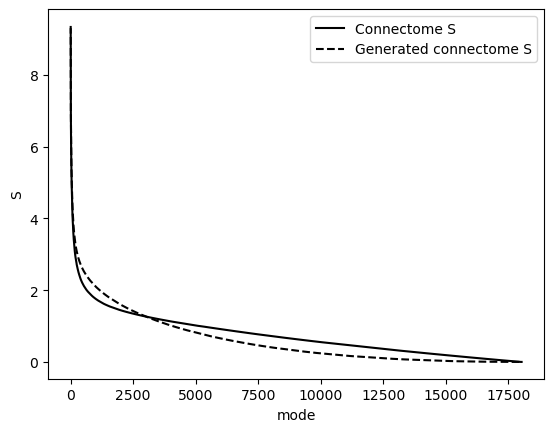

In [13]:
gamma_gen = torch.einsum('ij, ki -> jk', U_gen, V_gen.T)
plt.plot(S.cpu().detach().numpy(), alpha=1, color='k')
plt.plot(S_gen.cpu().detach().numpy(), alpha=1, color='k', linestyle='--')
plt.legend(['Connectome S', 'Generated connectome S'])
plt.xlabel('mode')
plt.ylabel('S')

In [ ]:
W_ = np.sqrt(6)*W
x, r = sample_activity(T_sim=500, dt_save=0.1, dt=0.1, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=100)
r = torch.from_numpy(r).type(torch.FloatTensor).to(0)[:,None,:]

In [13]:
W_gen_ = 10*W_gen
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
N = W_gen_.shape[0]
x0 = torch.randn(1, N, device=0) * torch.std(W).item()
x_gen, r_gen = sample_activity(T_sim=1500, dt_save=0.1, dt=0.1, W=W_gen_, phi_torch=phi_torch, x0=x0,
                               runga_kutta=True, T_save_delay=1000)

In [ ]:
r_ = r[:,0,:5000].cpu().detach().numpy()
C_phi = np.fft.irfft(np.abs(np.fft.rfft(r_, axis=0, norm='ortho'))**2)
r_gen_ = r_gen[:,:5000]
C_phi_gen = np.fft.irfft(np.abs(np.fft.rfft(r_gen, axis=0, norm='ortho'))**2)

In [ ]:
W_gen_.std() * np.sqrt(W_gen_.shape[0])

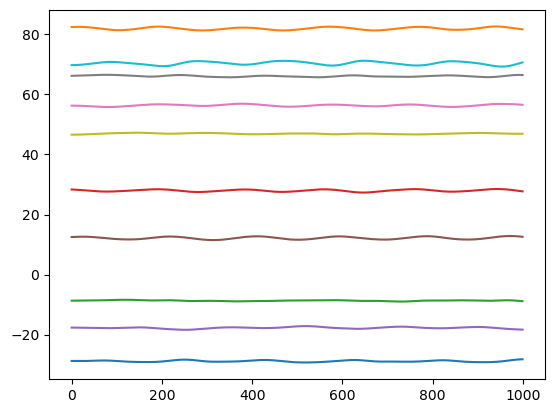

In [14]:
plt.plot(x_gen[:1000,:10])
#plt.ylim([-2, 2])

In [ ]:
plt.plot(C_phi[:1000].mean(1))
plt.plot(C_phi_gen[:1000].mean(1))

In [ ]:
plt.plot(r[:,0,0].cpu().detach().numpy())
plt.plot(r_gen_[:,10])

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': None, 'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [ ]:
###Truncate file above
file_name = 'hemibrain_theory'
job_name = 'USV_LDR_USV_hemibrain'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

In [ ]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=64, n_hours=24, n_gpus=1)
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
submit_job(job_script_path, n_jobs, execute=False)

In [ ]:
###Get job status
get_ipython().system('squeue -u om2382')

In [ ]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'USV_LDR_USV_hemibrain'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
configs_array, results_array, key_order, sim_dict = unpack_processed_data(job_script_path)

In [ ]:
job_name = 'LDRG_fit_correction_2'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
configs_array_1, results_array_1, key_order_1, sim_dict_1 = unpack_processed_data(job_script_path)

In [ ]:
# Load the variables from the npz file
data = np.load("/home/om2382/datasets/hemibrain_neurotransmitters-2/processed_data_2.npz")

# Extract variables
U_sk = data['U_sk']
s_sk = data['s_sk']
V_sk = data['V_sk']

In [ ]:
plt.plot(s_sk/s_sk[0])
plt.plot(results_array[0,1,:]/results_array[0,1,0])

In [ ]:
gamma_diag = np.einsum('ik, ik -> k', U_sk, V_sk)
#plt.plot(gamma_diag)
plt.plot(results_array[0,0,:])

In [ ]:
results_array
plt.imshow(results_array[1, :,:,1,0,0])
plt.colorbar()

In [ ]:
plot_3d_or_4d_array_of_config_results(configs_array, results_array[:,:,:,:,0], key_order)

In [ ]:
plt.imshow(results_array[2,:,:,2,0,0])
plt.colorbar()

In [ ]:
configs_array

In [ ]:
#does spectrum of activity match shape of D when PR_D is small?
#double check shape invariance with N
#look at this fly activity data

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    lags = results_array[i,0,0]
    for k in range(10):
        ax[i].plot(lags, results_array[i,k,1], color='C0', alpha=0.3)
    ax[i].plot(lags, np.roll(results_array[i,k,2], -1), color='C1')
    ax[i].plot(lags, results_array[i,:,1].mean(0), color='C0')

In [ ]:
results_array.shape

In [ ]:
configs_array

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(7, 7))
i_g = 0
for i in range(2):
    for j in range(2):
        lags = results_array[0,0,0,0,0]
        for k in range(10):
            ax[i,j].plot(lags, results_array[i_g,i,j,k,1], color='C0', alpha=0.3)
        ax[i,j].plot(lags, np.roll(results_array[i_g,i,j,k,2], -1), color='C1')
        ax[i,j].plot(lags, results_array[i_g,i,j,:,1].mean(0), color='C0')
        ax[i,j].set_title(r'$g = {}, \alpha = {}, \rho_m = {}$'.format(configs_array['g'][i_g],
                                                                          configs_array['alpha'][i%2],
                                                                          configs_array['max_rho'][j]))
        ax[i,j].set_xlim([-30, 30])
#fig.savefig('figs/LDR_sym_psi_fit_g={}_zoom.pdf'.format(configs_array['g'][i_g]))

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(9, 15))
for i in range(4):
    for j in range(2):
        lags = results_array[i//2,0,0,0,0]
        for k in range(10):
            ax[i,j].plot(lags, results_array[i//2,i%2,j,k,1], color='C0', alpha=0.3)
        ax[i,j].plot(lags, np.roll(results_array[i//2,i%2,j,k,2], -1), color='C1')
        ax[i,j].plot(lags, results_array[i//2,i%2,j,:,1].mean(0), color='C0')
        ax[i,j].set_title(r'$g = {}, \alpha = {}, \rho_m = {}$'.format(configs_array['g'][i//2],
                                                                          configs_array['alpha'][i%2],
                                                                          configs_array['max_rho'][j]))

In [ ]:
from scipy.stats import bootstrap
mean_pr = results_array[:,:,0].mean(-1)
sem_pr = results_array[:,:,0].std(-1)/np.sqrt(10)
sem_pr = bootstrap((results_array[:,:,0],), np.mean, axis=1)
#plt.errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
plt.fill_between(configs_array['g'], sem_pr.confidence_interval.low,
                 sem_pr.confidence_interval.high)
for i_seed in range(10):
    pass
    #plt.plot(configs_array['g'], results_array[:,i_seed,0], '.', color='C0')
plt.plot(configs_array['g'], results_array[:,0,1], color='k')
plt.ylim([0, 0.07])

In [ ]:
sem_pr.confidence_interval.low

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
#g_eff plot
i_alpha = 1
i_G = 1
mean_pr = results_array[:,i_alpha,i_G,:,0].mean(-1)
sem_pr = results_array[:,i_alpha,i_G,:,0].std(-1)/np.sqrt(10)
ax[0].errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
ax[0].plot(configs_array['g'], results_array[:,i_alpha,i_G,0,1], color='k')
ax[0].set_ylim([0, 0.1])

In [ ]:
plt.plot(results_array[:,:,:,:,0].flatten(), results_array[:,:,:,:,1].flatten(), '.')
x = np.arange(0, 0.15, 0.01)
plt.plot(x, x)
plt.xlim([0, 0.15])
plt.ylim([0, 0.15])

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(results_array[:,:,:,:,0].mean(-1).flatten(), results_array[:,:,:,:,1].mean(-1).flatten(), '.')
x = np.arange(0, 0.15, 0.01)
plt.plot(x, x)
plt.xlim([0, 0.15])
plt.ylim([0, 0.15])
plt.axis('equal')

In [ ]:
configs_array

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(8, 14))
for i in range(4):
    for j in range(3):
        ax[i,0].set_ylabel(r'$\alpha = {}$'.format(configs_array['alpha'][i]))
        ax[0,j].set_title(r'$PR_G = {}$'.format(configs_array['PR_G'][j]))
        if i !=0 or j!= 0:
            ax[i,j].set_xticks([])
        if j!=0:
            ax[i,j].set_yticks([])
        else:
            ax[i,j].set_yticks([0, 0.05, 0.1, 0.13])
        for k in range(10):
            ax[i,j].plot(configs_array['g'], results_array[:,i,j,k,0], '.', color='C0', alpha=0.2)
        ax[i,j].plot(configs_array['g'], results_array[:,i,j,0,1], color='k')
        ax[i,j].plot(configs_array['g'], results_array[:,i,j,:,0].mean(-1), color='C0', alpha=1)
        ax[i,j].set_ylim([0, 0.13])
ax[0,0].set_xlabel(r'$g_{eff}$')
ax[0,0].set_xticks(configs_array['g'])
#fig.savefig('figs/PR_phi_match.pdf')

In [ ]:
for i_g in range(3):
    fig, ax = plt.subplots(3, 2, figsize=(8, 8))
    lags = results_array[0,0,0,0,0]
    N = 4000
    for i in range(3):
        for j in range(2):
            D = np.ones(int(configs_array['alpha'][i] * N))
            G = np.exp(-configs_array['beta'][j]*np.arange(N)/N)
            PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
            PR_D = (np.sum(D**2))**2/np.sum(D**4)/N
            ax[i,0].set_ylabel('PR D = {}'.format(np.round(PR_D, 2)))
            ax[0,j].set_title('PR G = {}'.format(np.round(PR_G, 2)))
            ax[i,j].plot(lags, results_array[i_g,i,j,:,1,:].mean(0), '.', color='C0')
            for k in range(20):
                ax[i,j].plot(lags, results_array[i_g,i,j,k,1,:], color='C0', alpha=0.2)
            ax[i,j].plot(lags[1:], results_array[i_g,i,j,0,2,1:], color='C1')
    fig.savefig('figs/LDRG_theory_match_lowPR_g={}.pdf'.format(configs_array['g'][i_g]))

In [ ]:
for i_g in [0]:
    fig, ax = plt.subplots(5, 5, figsize=(8, 8))
    lags = results_array[0,0,0,0,0]
    N = 4000
    for i in range(5):
        for j in range(5):
            D = np.ones(int(configs_array['alpha'][i] * N))
            G = np.exp(-configs_array['beta'][j]*np.arange(N)/N)
            PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
            PR_D = (np.sum(D**2))**2/np.sum(D**4)/N
            ax[i,0].set_ylabel('PR D = {}'.format(np.round(PR_D, 2)))
            ax[0,j].set_title('PR G = {}'.format(np.round(PR_G, 2)))
            ax[i,j].plot(lags, results_array[i_g,i,j,:,1,:].mean(0), '.', color='C0')
            for k in range(5):
                ax[i,j].plot(lags, results_array[i_g,i,j,k,1,:], color='C0', alpha=0.2)
            ax[i,j].plot(lags[1:], results_array_1[2,i,j,0,1,1:], color='C1')
    #fig.savefig('figs/LDRG_theory_match_g={}.pdf'.format(configs_array['g'][i_g]))

In [ ]:
for i_g in range(5):
    fig, ax = plt.subplots(5, 5, figsize=(8, 8))
    lags = results_array[0,0,0,0,0]
    N = 4000
    for i in range(5):
        for j in range(5):
            D = np.ones(int(configs_array['alpha'][i] * N))
            G = np.exp(-configs_array['beta'][j]*np.arange(N)/N)
            PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
            PR_D = (np.sum(D**2))**2/np.sum(D**4)/N
            ax[i,0].set_ylabel('PR D = {}'.format(np.round(PR_D, 2)))
            ax[0,j].set_title('PR G = {}'.format(np.round(PR_G, 2)))
            ax[i,j].plot(lags, results_array[i_g,i,j,:,1,:].mean(0), '.', color='C0')
            for k in range(5):
                ax[i,j].plot(lags, results_array[i_g,i,j,k,1,:], color='C0', alpha=0.2)
            ax[i,j].plot(lags, results_array[i_g,i,j,0,2,:], color='C1')
    #fig.savefig('figs/LDRG_theory_match_g={}.pdf'.format(configs_array['g'][i_g]))

In [ ]:
fig, ax = plt.subplots(6, 1, figsize=(4, 12))
T_window = 100
dT = 0.05
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
lags = np.arange(0, T_window, dT)
n_lags = int(T_window/dT)
lags_full = np.concatenate([-lags[-n_lags:][::-1], lags[1:n_lags], np.array([lags[-1]])])
for i in range(6):
    
    #Choose g
    g = configs_array['g'][i]
    
    ### --- Compute single-unit properties
    d = compute_Delta_0(g=g)
    time, Delta_T = integrate_potential(d, g=g, tau_max=T_window, N_tau=int(T_window/dT))
    Delta_T = fix(Delta_T)
    C_Phi_half = compute_C_simple(d, Delta_T)
    alpha = compute_phi_prime_avg(d)
    
    ### --- Compute Psi from theory --- ###

    #Define relevant single-unit functions
    C_phi = np.concatenate([C_Phi_half[-n_lags:][::-1],
                            C_Phi_half[1:n_lags],
                            np.array([C_Phi_half[-1]])])
    C_phi_omega = fft(C_phi, dT)
    T = len(C_phi)
    t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
    sampfreq = 1/dT
    w = 2*np.pi*sampfreq*t_indices/T
    C_phi_C_phi = np.multiply.outer(C_phi_omega, C_phi_omega)
    S_phi = alpha/(np.sqrt(2*np.pi)*(1 + 1j*w))
    S_phi_S_phi = np.multiply.outer(S_phi, S_phi)

    #Compute psi for iid random network
    Psi_PRX = (1/(np.abs(1 - 2*np.pi*(g**2) * (S_phi_S_phi))**2) - 1)*C_phi_C_phi
    Psi_PRX_tau = ifft(Psi_PRX, dT)
    Psi_tau_tau = np.diag(Psi_PRX_tau)
    
    ### --- Double check with David's code --- ###
    Psi_tau_2 = compute_psi_theory(symmetrize(Delta_T), g, dT)
    Ptt2 = np.diag(Psi_tau_2)
    Psi_tau_tau_2 = np.concatenate([Ptt2[-len(Ptt2)//2:], Ptt2[:len(Ptt2)//2]])

    for j in range(5):
        ax[i].plot(results_array[i,j,0,:],
                   results_array[i,j,1,:], color='C0', alpha=0.1)
    
    ax[i].plot(results_array[i,j,0,:],
               results_array[i,:,1,:].mean(0), color='C0', alpha=1)
    ax[i].plot(lags_full, Psi_tau_tau, color='C1')
    ax[i].plot(lags_full, Psi_tau_tau_2, color='C2')
    ax[i].set_ylim([0, 14])